

### Overview
#### Data is downloaded from - https://archive.ics.uci.edu/ml/datasets/online+retail

  * The steps are broadly:
 
   * Read and understand the data
   * Clean the data
   * Prepare the data for modelling
   * Modelling
   * Final analysis and recommendations

### 1. Read and visualise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# read the dataset
retail_df = pd.read_excel(r"C:\Users\Banoth Sudhar\Downloads\Online Retail(1).xlsx")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 2. Clean the data


In [4]:

# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)



InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [5]:


# drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape



(406829, 8)

In [6]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:


# new column: amount 
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34



### 3. Prepare the data for modelling

        R (Recency): Number of days since last purchase
        F (Frequency): Number of tracsactions
        M (Monetary): Total amount of transactions (revenue contributed)



In [8]:
# monetary
amount = retail_df.groupby('CustomerID')['amount'].sum()
amount = amount.reset_index()
amount.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [9]:
# frequency
# count function gets the count of each item
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].nunique()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [10]:
# merge the two dfs
grouped_df = pd.merge(amount, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,7
2,12348.0,1797.24,4
3,12349.0,1757.55,1
4,12350.0,334.40,1


In [12]:
# recency
# convert to datetime

retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [13]:


# compute the max date
max_date = max(retail_df['InvoiceDate'])
max_date



Timestamp('2011-12-09 12:50:00')

In [14]:
# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [15]:
# recency
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [16]:
# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,7,1 days 20:58:00
2,12348.0,1797.24,4,74 days 23:37:00
3,12349.0,1757.55,1,18 days 02:59:00
4,12350.0,334.40,1,309 days 20:49:00


In [17]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,7,1
2,12348.0,1797.24,4,74
3,12349.0,1757.55,1,18
4,12350.0,334.40,1,309


In [18]:


# rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape



(4372, 3)

In [19]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.231001,-0.329362,2.322023
1,0.293432,0.206102,-0.893733
2,-0.012316,-0.115176,-0.169196
3,-0.017146,-0.436455,-0.725005
4,-0.190312,-0.436455,2.163220


## 4. Modelling


In [20]:


# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)



C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [21]:
kmeans.labels_

array([1, 3, 3, ..., 3, 3, 3])

In [22]:
# help(KMeans)

## Finding the Optimal Number of Clusters
### Elbow Curve Method

C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Banoth Sudhar\a

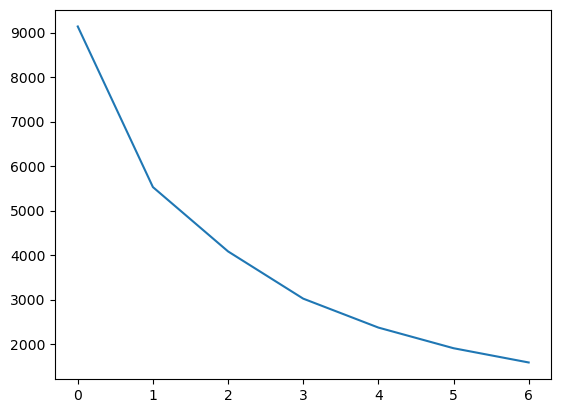

In [23]:
# elbow-curve
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)


## Silhouette Analysis

#### p is the mean distance to the points in the nearest cluster that the data point is not a part of

#### q is the mean intra-cluster distance to all the points in its own cluster.

    The value of the silhouette score range lies between -1 to 1.

    A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

    A score closer to -1 indicates that the data point is not similar to the data points in its cluster.


In [24]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.8953127225457423


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.5870518522944161


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.6113601158699812


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.589875763645933


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.5798204930661758


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.5178505333087383


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.49065083951225147


In [25]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [26]:
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0])

In [31]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,7,1,0
2,12348.0,1797.24,4,74,0
3,12349.0,1757.55,1,18,0
4,12350.0,334.40,1,309,1


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

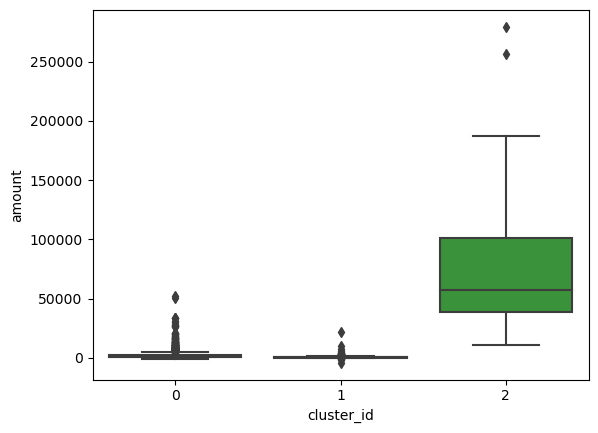

In [32]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

⭐Important Observations :
* Cluster 2 represents high monetary customers.
* Cluster 0 and 1 has high overlap.

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

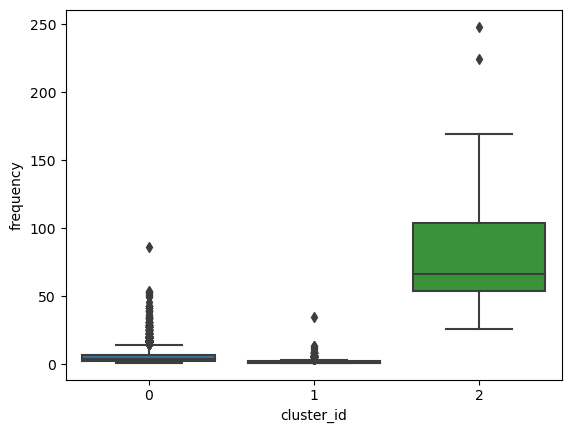

In [33]:
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)


⭐Important Observations :
* Cluster 2 represents high frequency customers.
* Cluster 0 and 1 has high overlap.

<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

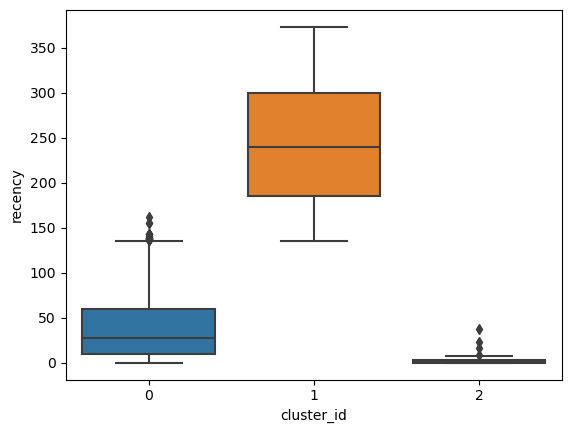

In [34]:
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)


⭐Important Observations :
* Cluster 2 represents high recency customers.
* Cluster 0 represents least recent.

## 5. Treating the Outliers


In [35]:
grouped_df.describe()

,CustomerID,amount,frequency,recency,cluster_id
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,15299.677722,1898.459701,5.075480,91.047118,0.264410
std,1722.390705,8219.345141,9.338754,100.765435,0.452842
min,12346.000000,-4287.630000,1.000000,0.000000,0.000000
25%,13812.750000,293.362500,1.000000,16.000000,0.000000
50%,15300.500000,648.075000,3.000000,49.000000,0.000000
75%,16778.250000,1611.725000,5.000000,142.000000,1.000000
max,18287.000000,279489.020000,248.000000,373.000000,2.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x1eab0389550>,
 'caps': [<matplotlib.lines.Line2D at 0x1eab0389af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1eab0389280>],
 'medians': [<matplotlib.lines.Line2D at 0x1eab20d00d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1eab20d03a0>],
 'means': []}

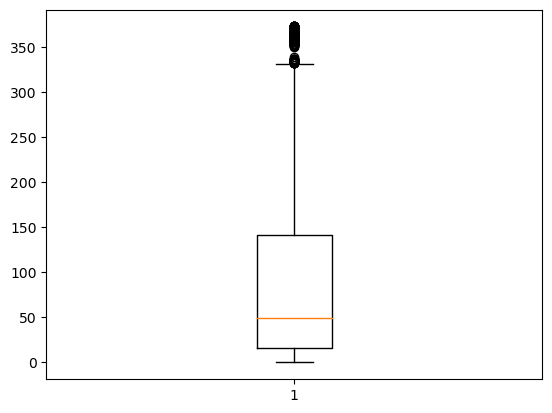

In [36]:
plt.boxplot(grouped_df['recency'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1eab5596070>,
 'caps': [<matplotlib.lines.Line2D at 0x1eab5596610>,
 'boxes': [<matplotlib.lines.Line2D at 0x1eab554dd60>],
 'medians': [<matplotlib.lines.Line2D at 0x1eab5596bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1eab5596e80>],
 'means': []}

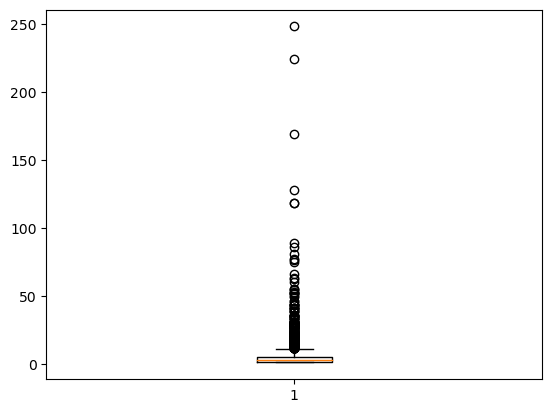

In [37]:
plt.boxplot(grouped_df['frequency'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1eaa9ae8fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1eaacbab5b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1eaa9ae8d00>],
 'medians': [<matplotlib.lines.Line2D at 0x1eaacbabb50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1eaacbabe20>],
 'means': []}

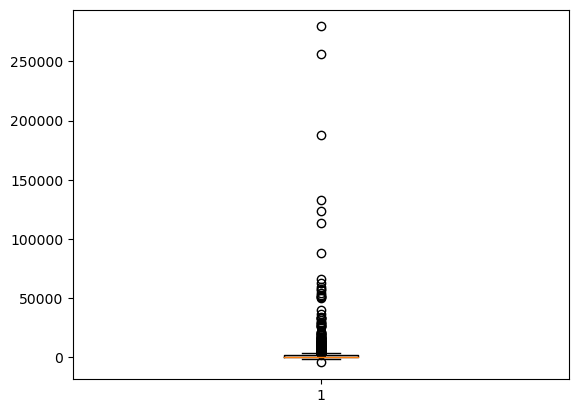

In [38]:
plt.boxplot(grouped_df['amount'])

In [39]:
# two types of outliers:
# - statistical
# - domain specific

In [40]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.10)
Q3 = grouped_df.amount.quantile(0.90)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.10)
Q3 = grouped_df.recency.quantile(0.90)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.10)
Q3 = grouped_df.frequency.quantile(0.90)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]

In [41]:
# 2. rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape


(4209, 3)

In [42]:


rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()



,amount,frequency,recency
0,-0.844245,-0.498797,2.280654
1,2.423353,0.801164,-0.919107
2,0.518321,0.021187,-0.198173
3,0.488230,-0.758789,-0.751218
4,-0.590722,-0.758789,2.122641



### 6. Modelling
#### Finding the Optimal Number of Clusters
### SSD

C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Banoth Sudhar\a

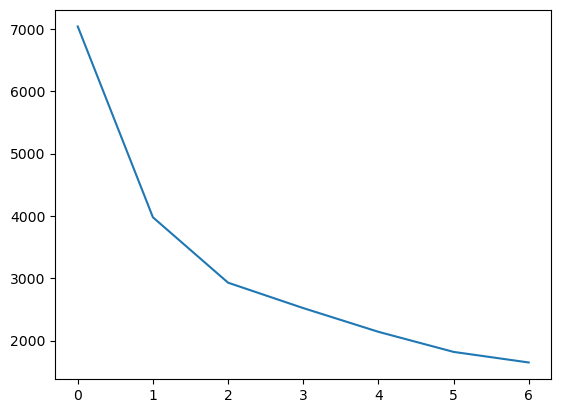

In [43]:


# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)



In [44]:


# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    



C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.4979580758288508


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.49030867779024295


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.46060609327485974


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.4049759159738527


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.383107333650799


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.3981680318592676


C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.38716901908746737


In [46]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

C:\Users\Banoth Sudhar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [47]:
kmeans.labels_

array([2, 1, 0, ..., 0, 1, 0])

In [48]:


# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()



,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,7,1,1
2,12348.0,1797.24,4,74,0
3,12349.0,1757.55,1,18,0
4,12350.0,334.40,1,309,2


In [49]:
grouped_df.cluster_id.value_counts()

0    2499
2    1058
1     652
Name: cluster_id, dtype: int64

<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

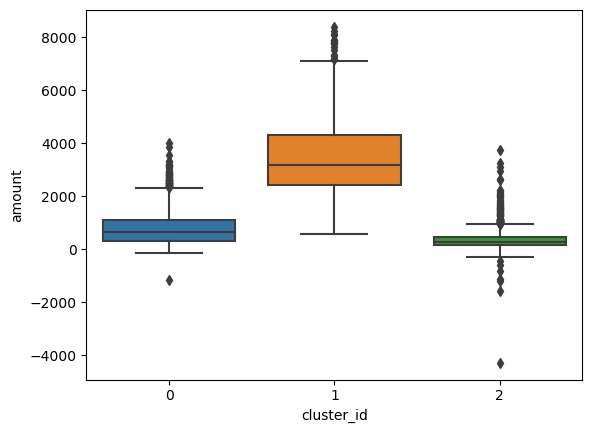

In [50]:
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)


⭐Important Observations :
* Cluster 2 represents high monetary customers.
* Cluster 1 represents least monetary customers.

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

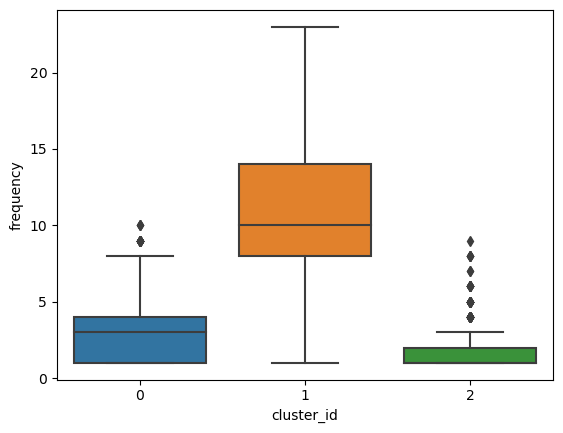

In [51]:
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)


⭐Important Observations :
* Cluster 2 represents high frequency customers.
* Cluster 1 represents least frequency customers.

<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

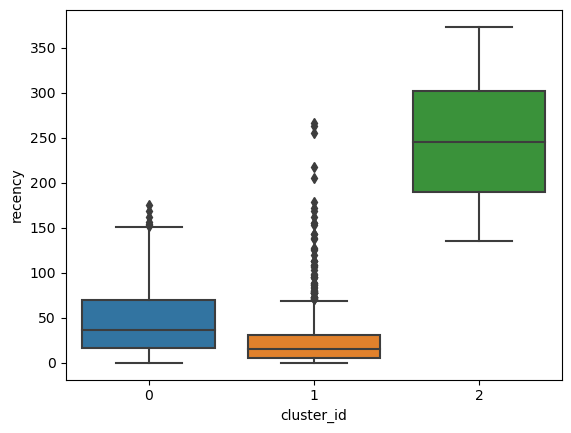

In [52]:
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

⭐Important Observations :
* Cluster 2 represents high recency customers.
* Cluster 1 represents least recency customers.